## Introduction
The Scipy framework builds on top of the low-level Numpy library for multidimensional arrays, and provides a large number of higher-level scientific algorithms. Some of the topics that Scipy covers are:
- Special functions
- Integration
- Optimization
- Interpolation
- Fourier Transforms
- Signal Processing
- Linear Algebra
- Sparse Eigenvalue Problems
- Statistics
- Multi-dimensional image processing 
- File IO 

To access the Scipy package in a Python program, we start by importing everything from the `scipy` module.

In [1]:
from scipy import *

If we only need to use part of the Scipy library we can selectively include only those modules we are interested in. For example, to include th linear algebra package under the name `la`, we can do:

In [2]:
import scipy.linalg as la

## Special functions
A large number of mathematical special functions are important for many computational problems.

In [3]:
# Here we will use the functions jn and yn, which are 
# the Bessel functions of the first and second kind and 
# real-values order. We also include the function 
# jn_zeros and yn_zeros that gives the zeros of the 
# functions jn and yn.
from scipy.special import jn, yn, jn_zeros, yn_zeros

In [4]:
n = 0 # order
x = 0.0

# Bessel function of first kind
print("J_%d(%f) = %f" % (n, x, jn(n, x)))

x = 1.0
# Bessel function of second kind
print("Y_%d(%f) = %f" % (n, x, yn(n, x)))

J_0(0.000000) = 1.000000
Y_0(1.000000) = 0.088257


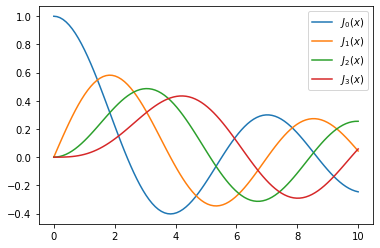

In [5]:
import matplotlib
import matplotlib.pyplot as plt

x = linspace(0, 10, 100)

fig, ax = plt.subplots()
for n in range(4):
    ax.plot(x, jn(n, x), label=r"$J_%d(x)$" % n)
ax.legend();

In [6]:
# zeros of Bessel functions
n = 0 # order
m = 4 # number of roots to compute
jn_zeros(n, m)

array([ 2.40482556,  5.52007811,  8.65372791, 11.79153444])

## Integration

### Numerical integration: quadrature
Numerical evaluation of a function of the type $\displaystyle \int_a^b f(x)  dx$ is called *numerical quadrature*, or simply *quadrature*. Scipy provides a series of functions for different kind of quadrature, for example the `quad`, `dblquad`, and `tplquad`.

In [7]:
from scipy.integrate import quad, dblquad, tplquad

In [8]:
# define a simple function for the integrand
def f(x):
    return x

In [9]:
x_lower = 0 # the lower limit of x
x_upper = 1 # the upper limit of x

val, abserr = quad(f, x_lower, x_upper)

print("integral value =", val, ", absolute error =", abserr)


integral value = 0.5 , absolute error = 5.551115123125783e-15


In [10]:
def integrand(x,n):
    """
    Bessel function of first kind and order n.
    """
    return jn(n,x)

x_lower = 0
x_upper = 10

val, abserr = quad(integrand, x_lower, x_upper, args=(3,))

print(val, abserr)

0.7366751370811073 9.389126882496413e-13


For simple functions we can use a lambda function.

In [11]:
val, abserr = quad(lambda x: exp(-x**2), -Inf, Inf)

print("numerical =", val, abserr)

analytical = sqrt(pi)
print("analytical =", analytical)

numerical = 1.7724538509055159 1.4202636756659625e-08
analytical = 1.7724538509055159


High-dimesional integration works in the same way:

In [12]:
def integrand(x,y):
    return exp(-x**2-y**2)

x_lower = 0
x_upper = 10
y_lower = 0
y_upper = 10

val, abserr = dblquad(integrand, x_lower, x_upper, lambda x: y_lower, lambda x: y_upper)

print(val, abserr)

0.7853981633974476 1.3753098510218537e-08


Note how we had to pass lambada functions for the limits for the y integration, since these in general can be finctions of x.

## Ordinary differential equations (ODEs)
Scipy provides two different ways to solve ODEs: an API based on the function `odeint`, and object-oriented API based on the class `ode`. Usually `odeint` is easier to get with, but the `ode` class offers some finer level of control.

In [13]:
from scipy.integrate import odeint, ode

A system of ODEs are usually formulated on standard form before it is attacked numerically. The standard form is:

$y' = f(y,t)$

where 

$y = [y_1(t),y_2(t),....,y_n(t)]$

and $f$ is some function that gives the derivatives of the function $y_i(t)$. To solve an ODE we need to know the function $f$ and an initial condition, $y(0)$.

Once we have defined the Python function $f$ and array $y_0$, we can use the `odeint` function as:

$y_t = odeint(f,y_0,t)$

where $t$ is an array with the time-coordinates for which to solve the ODE problem. $y_t$ is an array with one row for each point in time in $t$, where each column corresponds to a solution $y_i(t)$ at that point in time.

#### Example: double pendum

![](resources/Double-compound-pendulum-dimensioned.svg)

${\dot \theta_1} = \frac{6}{m\ell^2} \frac{ 2 p_{\theta_1} - 3 \cos(\theta_1-\theta_2) p_{\theta_2}}{16 - 9 \cos^2(\theta_1-\theta_2)}$

${\dot \theta_2} = \frac{8}{m\ell^2} \frac{8 p_{\theta_2} - 3 \cos(\theta_1-\theta_2) p_{\theta_1}}{16-9 \cos^2(\theta_1-\theta_2)}$

${\dot p_{\theta_1}} = -\frac{1}{2} m \ell^2 \left [ {\dot \theta_1} {\dot \theta_2} \sin (\theta_1-\theta_2) + 3 \frac{g}{\ell} \sin \theta_1 \right ]$

${\dot p_{\theta_2}} = -\frac{1}{2} m \ell^2 \left [ -{\dot \theta_1} {\dot \theta_2} \sin (\theta_1-\theta_2) +  \frac{g}{\ell} \sin \theta_2 \right]$

To make the Python code simpler to follow, let's introduce new variables names and the vector notation: $x = [\theta_1,\theta_2,p_{\theta_1},p_{\theta_2}]$

${\dot x_1} = \frac{6}{m\ell^2} \frac{ 2 x_3 - 3 \cos(x_1-x_2) x_4}{16 - 9 \cos^2(x_1-x_2)}$

${\dot x_2} = \frac{6}{m\ell^2} \frac{ 8 x_4 - 3 \cos(x_1-x_2) x_3}{16 - 9 \cos^2(x_1-x_2)}$

${\dot x_3} = -\frac{1}{2} m \ell^2 \left [ {\dot x_1} {\dot x_2} \sin (x_1-x_2) + 3 \frac{g}{\ell} \sin x_1 \right ]$

${\dot x_4} = -\frac{1}{2} m \ell^2 \left [ -{\dot x_1} {\dot x_2} \sin (x_1-x_2) +  \frac{g}{\ell} \sin x_2 \right]$

In [14]:
g = 9.82
L = 0.5
m = 0.1

def dx(x,t):
    """
    The right-hand side of the pendulum ODE
    """
    x1, x2, x3, x4 = x[0], x[1], x[2], x[3]

    dx1 = 6.0/(m*L**2) * (2 * x3 - 3 * cos(x1-x2) * x4)/(16 - 9 * cos(x1-x2)**2)
    dx2 = 6.0/(m*L**2) * (8 * x4 - 3 * cos(x1-x2) * x3)/(16 - 9 * cos(x1-x2)**2)
    dx3 = -0.5 * m * L**2 * ( dx1 * dx2 * sin(x1-x2) + 3 * (g/L) * sin(x1))
    dx4 = -0.5 * m * L**2 * (-dx1 * dx2 * sin(x1-x2) + (g/L) * sin(x2))
    
    return [dx1, dx2, dx3, dx4]

In [15]:
# choose an initial state
x0 = [pi/4, pi/2, 0, 0]

In [16]:
# time coordinate to solve the ODE for: from 0 to 10 seconds
t = linspace(0, 10, 250)

In [17]:
# solve the ODE porblem
x = odeint(dx, x0, t)

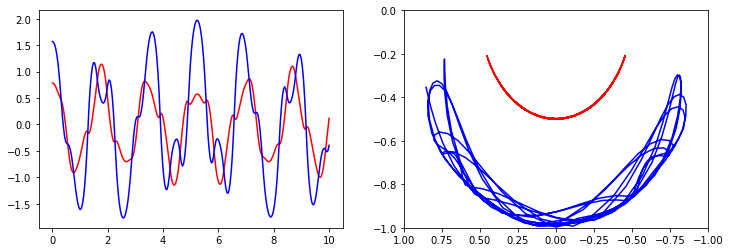

In [18]:
# plot the angles as a function of time

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(t, x[:, 0], 'r', label="theta1")
ax[0].plot(t, x[:, 1], 'b', label="theta2")

x1 = + L * sin(x[:, 0])
y1 = - L * cos(x[:, 0])

x2 = x1 + L * sin(x[:, 1])
y2 = y1 - L * cos(x[:, 1])

ax[1].plot(x1, y1, 'r', label="pendulum1")
ax[1].plot(x2, y2, 'b', label="pendulum2")
ax[1].set_ylim([-1, 0])
ax[1].set_xlim([1, -1]);

## Linear Algebra


### Linear equation systems
Linear equation systems on the matrix form

$Ax = b$

where $A$ is a matrix and $x, b$ are vectors, can be solved like this:

In [19]:
from scipy.linalg import *

In [20]:
A = array([[1,2,3], [4,10,6], [7,8,9]])
b = array([1,2,3])

In [21]:
x = solve(A, b)
x

array([ 1.16865582e-17, -1.02257384e-17,  3.33333333e-01])

In [22]:
# check
dot(A,x) - b

array([0., 0., 0.])

In [23]:
A = rand(3,3)
B = rand(3,3)

In [24]:
X = solve(A, B)
X

array([[-0.2404212 , -0.12348983, -0.08769975],
       [ 0.82282869,  0.97393787,  0.25558483],
       [ 0.70504866, -0.44399511,  0.407005  ]])

In [25]:
# check 
norm(dot(A,X) - B)

1.5202354861220294e-16

### Eigenvalues and eigenvectors
$Av_n = \lambda_nv_n$ where $v_n$ is the $n$th eigenvector and $\lambda_n$ is the $n$th eigenvalue. 

In [26]:
evals = eigvals(A)
evals

array([2.02641508+0.j        , 0.25038234+0.36630728j,
       0.25038234-0.36630728j])

In [27]:
evals, evecs = eig(A)
evals

array([2.02641508+0.j        , 0.25038234+0.36630728j,
       0.25038234-0.36630728j])

In [28]:
evecs

array([[ 0.70272443+0.j        ,  0.63020969+0.j        ,
         0.63020969-0.j        ],
       [ 0.55524377+0.j        , -0.44908014-0.32956075j,
        -0.44908014+0.32956075j],
       [ 0.44484013+0.j        , -0.18365721+0.50874602j,
        -0.18365721-0.50874602j]])

In [29]:
real(evals)

array([2.02641508, 0.25038234, 0.25038234])

In [30]:
n = 1
norm(dot(A,evecs[:,n]) - evals[n] * evecs[:,n])

2.772303046984639e-16

### Matrix operations

In [31]:
# the matrix inverse
inv(A)

array([[ 1.18016107,  0.6435199 , -1.88799591],
       [-0.99201635,  0.71968785,  1.28476471],
       [ 0.57590451, -1.24462254,  1.13723435]])

In [32]:
det(A)

0.39894507910029187

In [33]:
# norm of various orders
norm(A, ord=2), norm(A, ord=Inf)

(2.0454936494702136, 2.4818571194596792)

### Sparse matrices

Sparse matrices are often useful in numerical simulations dealing with large systems, if the problem can be described in matrix form where the matrices or vectors mostly contains zeros. Scipy has a good support for sparse matrices, with basic linear algebra operations (such as equation solving, eigenvalue calculations, etc).

There are many possible strategies for storing sparse matrices in an efficient way. Some of the most common are the so-called coordinate form (COO), list of list (LIL) form, and compressed-sparse column CSC (and row, CSR). Each format has some advantanges and disadvantages. Most computational algorithms (equation solving, matrix-matrix multiplication, etc) can be efficiently implemented using CSR or CSC formats, but they are not so intuitive and not so easy to initialize. So often a sparse matrix is initially created in COO or LIL format (where we can efficiently add elements to the sparse matrix data), and then converted to CSC or CSR before used in real calcalations.

In [34]:
from scipy.sparse import *

In [35]:
M = array([[1,0,0,0], [0,3,0,0], [0,1,1,0],[1,0,0,1]]); M

array([[1, 0, 0, 0],
       [0, 3, 0, 0],
       [0, 1, 1, 0],
       [1, 0, 0, 1]])

In [36]:
# convert from dense to sparse
A = csr_matrix(M); A

<4x4 sparse matrix of type '<class 'numpy.intc'>'
	with 6 stored elements in Compressed Sparse Row format>

In [37]:
# convert from sparse to dens
A.todense()

matrix([[1, 0, 0, 0],
        [0, 3, 0, 0],
        [0, 1, 1, 0],
        [1, 0, 0, 1]], dtype=int32)

More efficient way to create sparse matrices: create an empty matrix and populate with using matrix indexing (avoids creating a potentially large dense matrix).

In [38]:
A = lil_matrix((4,4)) # empty 4x4 sparse matrix
A[0,0] = 1
A[1,1] = 3
A[2,2] = A[2,1] = 1
A[3,3] = A[3,0] = 1
A

<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in List of Lists format>

In [39]:
A.todense()

matrix([[1., 0., 0., 0.],
        [0., 3., 0., 0.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.]])

Converting between different sparse matrix formats:

In [40]:
A

<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in List of Lists format>

In [41]:
A = csr_matrix(A); A

<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

We can compute with sparse matrices like with dense matrices:

In [42]:
A.todense()

matrix([[1., 0., 0., 0.],
        [0., 3., 0., 0.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.]])

In [43]:
(A*A).todense()

matrix([[1., 0., 0., 0.],
        [0., 9., 0., 0.],
        [0., 4., 1., 0.],
        [2., 0., 0., 1.]])

In [44]:
A.todense()

matrix([[1., 0., 0., 0.],
        [0., 3., 0., 0.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.]])

In [45]:
A.dot(A).todense()

matrix([[1., 0., 0., 0.],
        [0., 9., 0., 0.],
        [0., 4., 1., 0.],
        [2., 0., 0., 1.]])

In [46]:
v = array([1,2,3,4])[:,newaxis]; v

array([[1],
       [2],
       [3],
       [4]])

In [47]:
# sparse matrix - dense vector mutliplication
A * v

array([[1.],
       [6.],
       [5.],
       [5.]])

In [48]:
# same result with dense matrix - dense vector multiplication
A.todense() * v

matrix([[1.],
        [6.],
        [5.],
        [5.]])

### Optimization
Optimization (finding minima or maxima of a function) is a large field in mathematics, and optimization of complicated functions or in many variables can be rather involved. 

In [49]:
from scipy import optimize

In [50]:
def f(x):
    return 4*x**3 + (x-2)**2 + x**4

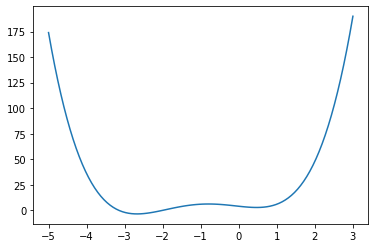

In [51]:
fig, ax = plt.subplots()
x = linspace(-5, 3, 100)
ax.plot(x,f(x));

In [52]:
x_min = optimize.fmin_bfgs(f,-2)
x_min

Optimization terminated successfully.
         Current function value: -3.506641
         Iterations: 5
         Function evaluations: 24
         Gradient evaluations: 8


array([-2.67298155])

In [53]:
optimize.fmin_bfgs(f,0.5)

Optimization terminated successfully.
         Current function value: 2.804988
         Iterations: 3
         Function evaluations: 15
         Gradient evaluations: 5


array([0.46961745])

We can also use the `brent` or `fminbound` functions. They have a bit different syntax and use different algorithms.

In [54]:
optimize.brent(f)

0.46961743402759754

In [55]:
optimize.fminbound(f,-4, 2)

-2.6729822917513886

### Finding a solution to a function
To find the root for a solution of the form $f(x) = 0$ we can use the `fsolve` function.

In [56]:
omega_c = 3.0
def f(omega):
    # a transcendental equation: resonance frequencies 
    # of a low-Q SQUID terminated microwave resonator
    return tan(2*pi*omega) - omega_c/omega

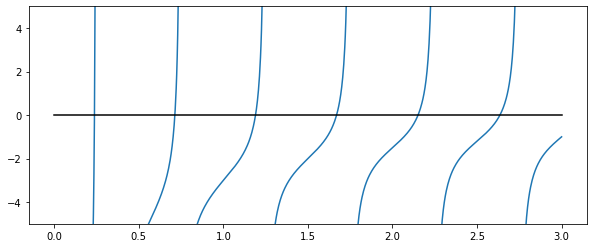

In [57]:
fig, ax  = plt.subplots(figsize=(10,4))
x = linspace(0, 3, 1000)
y = f(x)
mask = where(abs(y) > 50)
x[mask] = y[mask] = NaN # get rid of vertical line when                                             # the function flip sign
ax.plot(x, y)
ax.plot([0, 3], [0, 0], 'k')
ax.set_ylim(-5,5);

In [58]:
optimize.fsolve(f,0.1)

array([0.23743014])

In [59]:
optimize.fsolve(f,0.6)

array([0.71286972])

In [60]:
optimize.fsolve(f,1.1)

array([1.18990285])

### Interpolation

Interpolation is simple and convenient in scipy: The `interp1d` function, when given arrays describing X and Y data, returns and object that behaves like a function that can be called for an arbitrary value of x (in the range covered by X), and it returns the corresponding interpolated y value:


In [61]:
from scipy.interpolate import *

In [62]:
def f(x):
    return sin(x)

In [63]:
n = arange(0, 10)  
x = linspace(0, 9, 100)

y_meas = f(n) + 0.1 * randn(len(n)) # simulate                                                                   # measurement with noise
y_real = f(x)

linear_interpolation = interp1d(n, y_meas)
y_interp1 = linear_interpolation(x)

cubic_interpolation = interp1d(n, y_meas, kind='cubic')
y_interp2 = cubic_interpolation(x)

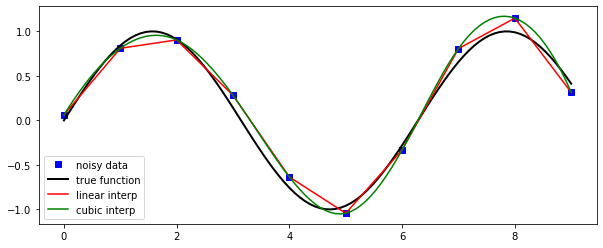

In [64]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(n, y_meas, 'bs', label='noisy data')
ax.plot(x, y_real, 'k', lw=2, label='true function')
ax.plot(x, y_interp1, 'r', label='linear interp')
ax.plot(x, y_interp2, 'g', label='cubic interp')
ax.legend(loc=3);

### Statistics
The `scipy.stats` module contains a large number of statistical distributions, statistical functions and tests. For a complete documentation of its features

In [65]:
from scipy import stats

In [66]:
# create a (discret) random variable with poissionian distribution

X = stats.poisson(3.5) # photon distribution for a coherent state with n=3.5                        # photons

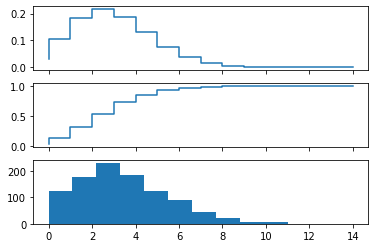

In [67]:
n = arange(0,15)

fig, axes = plt.subplots(3,1, sharex=True)

# plot the probability mass function (PMF)
axes[0].step(n, X.pmf(n))

# plot the commulative distribution function (CDF)
axes[1].step(n, X.cdf(n))

# plot histogram of 1000 random realizations of the stochastic variable X
axes[2].hist(X.rvs(size=1000));

In [68]:
# create a (continous) random variable with normal distribution
Y = stats.norm()

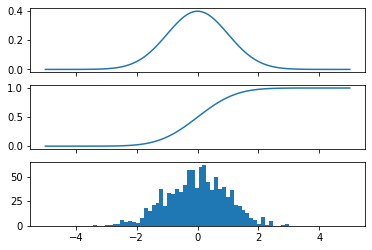

In [69]:
x = linspace(-5,5,100)

fig, axes = plt.subplots(3,1, sharex=True)

# plot the probability distribution function (PDF)
axes[0].plot(x, Y.pdf(x))

# plot the commulative distribution function (CDF)
axes[1].plot(x, Y.cdf(x));

# plot histogram of 1000 random realizations of the stochastic variable Y
axes[2].hist(Y.rvs(size=1000), bins=50);

In [70]:
X.mean(), X.std(), X.var() # Poisson distribution

(3.5, 1.8708286933869707, 3.5)

In [71]:
Y.mean(), Y.std(), Y.var() # Normal distribution

(0.0, 1.0, 1.0)

### Statistical tests
Test if two sets of (independent) random data comes from the same distribution:

In [72]:
t_statistic, p_value = stats.ttest_ind(X.rvs(size=1000), X.rvs(size=1000))

print("t-statistic =", t_statistic)
print("p-value =", p_value)

t-statistic = -0.3070416413087263
p-value = 0.7588436737242026


Since the p value is very large we cannot reject the hypothesis that the two sets of random data have different means.

To test if the mean of a single sample of data has mean 0.1 (the true mean is 0.0):

In [73]:
stats.ttest_1samp(Y.rvs(size=1000), 0.1)

Ttest_1sampResult(statistic=-2.4043780030137163, pvalue=0.016381193575106645)

Low p-value means that we can reject the hypothesis that the mean of Y is 0.1.

In [74]:
Y.mean()

0.0

In [75]:
stats.ttest_1samp(Y.rvs(size=1000), Y.mean())

Ttest_1sampResult(statistic=-0.09716904438462728, pvalue=0.9226116410014846)